# Group C

## Group members: Eloise Habek, Luca Jimenez, Zoe Monnard, Valentina Pucci

# Part 3: Regression for joint angles

## 1. Visualization and preprocessing

The dataset used here is subject 1's acquisition 1 data in the 8th database from the Ninapro dataset (https://ninapro.hevs.ch/instructions/DB8.html). 

This dataset includes detailed information about finger angles. Our objective now is to predict these finger angles using the EMG data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
sns.set_theme()

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

Loading the dataset and checking the data structure:

In [2]:
train_data = loadmat("S1_E1_A1.mat")
val_data = loadmat("S1_E1_A2.mat")
test_data = loadmat("S1_E1_A3.mat")

print("Dataset variables:")
for key in train_data.keys():
    if not key.startswith("__"):
        print(key)

Dataset variables:
subject
exercise
emg
acc
gyro
mag
glove
stimulus
repetition
restimulus
rerepetition


Now, we loaded in the EMG data. Checked the data structure printing data dimension and type.

In [3]:
emg_data_test = test_data["emg"]
emg_data_val = val_data["emg"]
emg_data_train = train_data["emg"]

print("EMG data dimension (train set): {}".format(emg_data_train.shape))
print("EMG data type (train set): {}".format(type(emg_data_train)))

EMG data dimension (train set): (2292526, 16)
EMG data type (train set): <class 'numpy.ndarray'>


Load in hand kinematics labels.

Glove data dimension (train set): (2292526, 5)
Glove data type (train set): <class 'numpy.ndarray'>


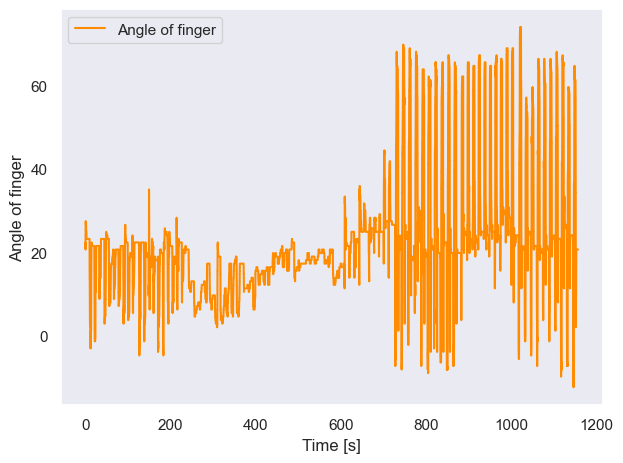

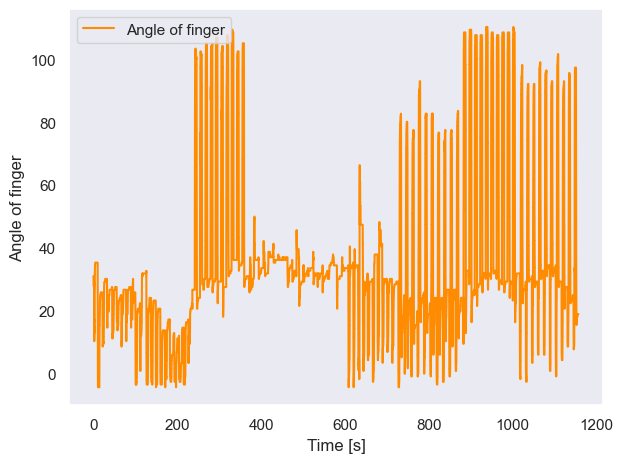

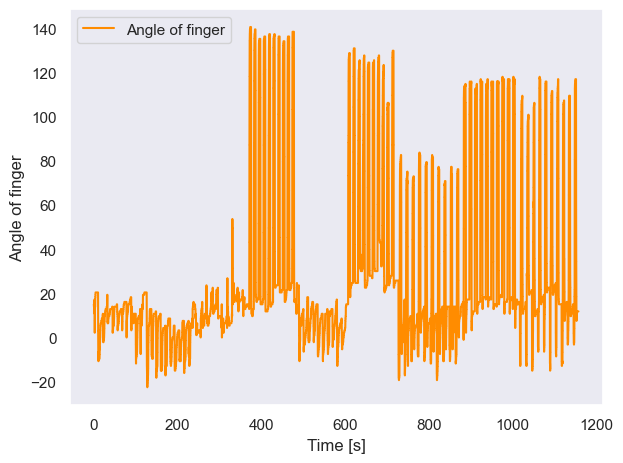

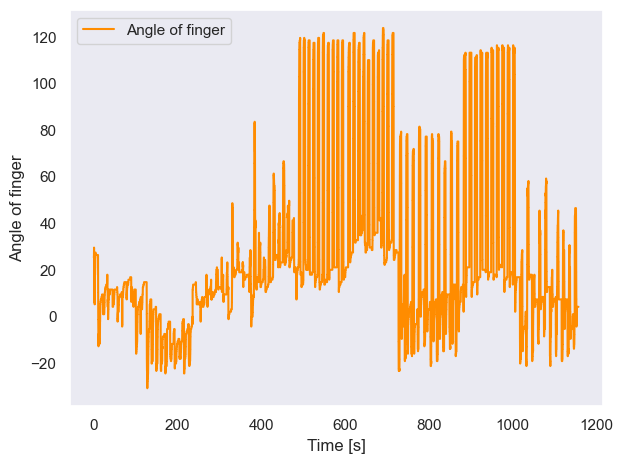

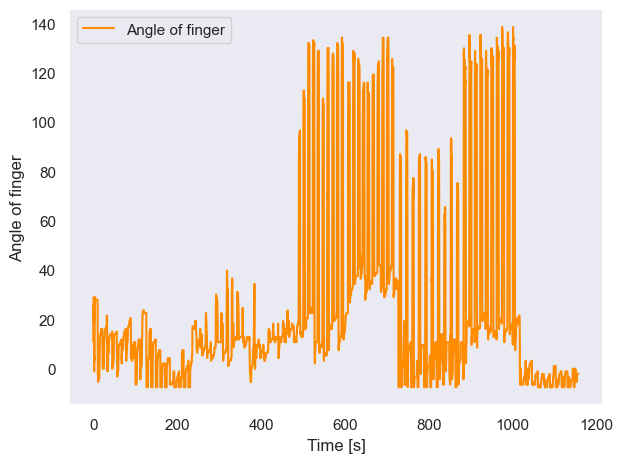

In [4]:
channels_to_keep = [2, 5, 7, 10, 13] # keep only channels 3, 6, 8, 11 and 14
glove_data_index_train = train_data["glove"][:, channels_to_keep] 
glove_data_index_val = val_data["glove"][:, channels_to_keep] 
glove_data_index_test = test_data["glove"][:, channels_to_keep] 

print("Glove data dimension (train set): {}".format(glove_data_index_train.shape))
print("Glove data type (train set): {}".format(type(glove_data_index_train)))


fs = 2000

time_steps = np.arange(0,emg_data_val.shape[0]/fs, 1/fs) #Time vector for plotting

for idx, channel in enumerate(channels_to_keep):
    fig, ax = plt.subplots()

    ax.plot(time_steps, glove_data_index_val[:, idx], color="darkorange", label="Angle of finger")
    ax.set_ylabel("Angle of finger")
    ax.set_xlabel("Time [s]")
    ax.grid(False)

    # Get handles and labels for legend
    finger_angle_handles, finger_angle_labels = ax.get_legend_handles_labels()

    # Create a single legend
    ax.legend(finger_angle_handles, finger_angle_labels, loc='upper left')
    plt.tight_layout()

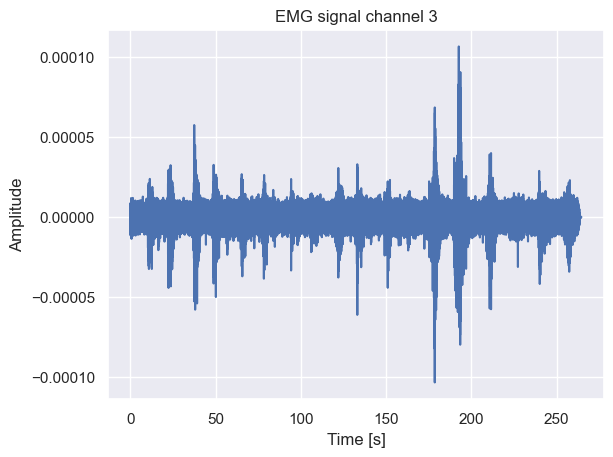

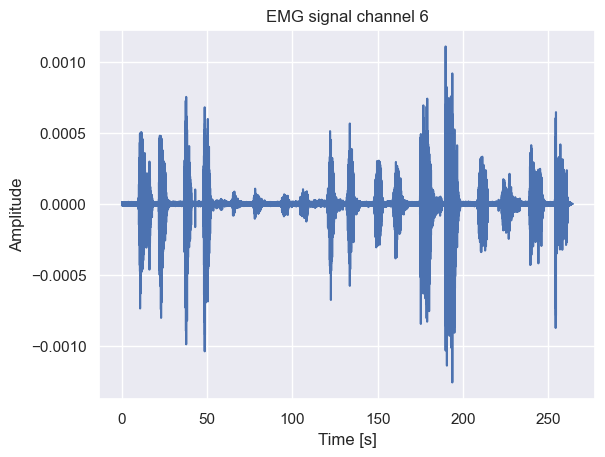

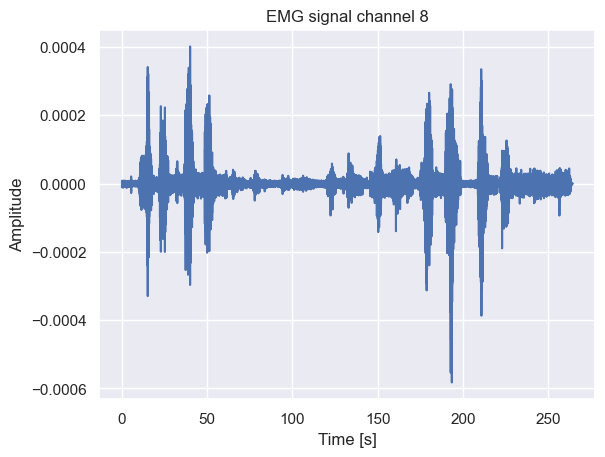

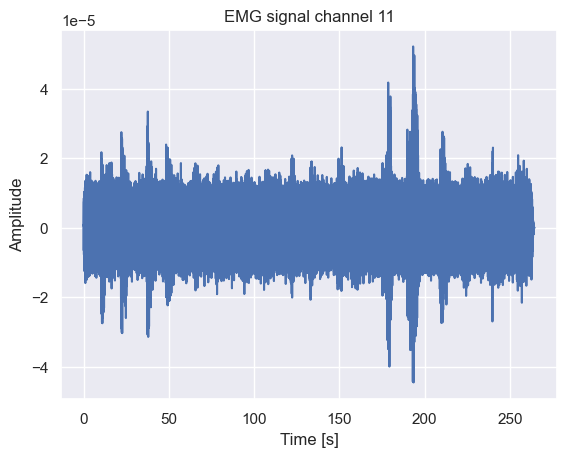

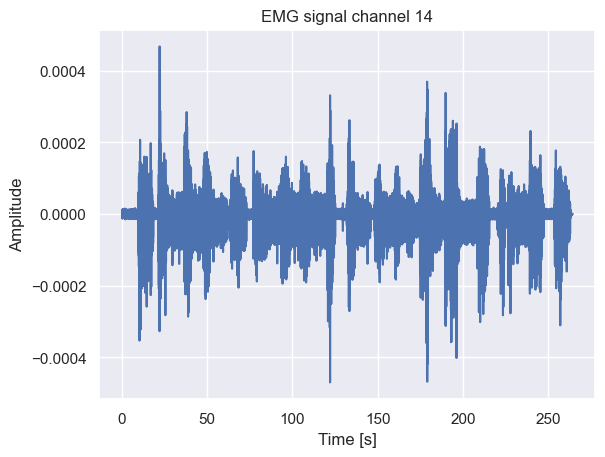

In [6]:
fs = 2000

time_steps = np.arange(0,emg_data_test.shape[0]/fs, 1/fs) #Time vector for plotting


# Plot all channels
plt.close("all")
for channel in channels_to_keep:
    fig, ax = plt.subplots()
    ax.plot(time_steps[:], emg_data_test[:, channel],)   
    ax.set_title("EMG signal channel {}".format(channel+1))
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Amplitude")

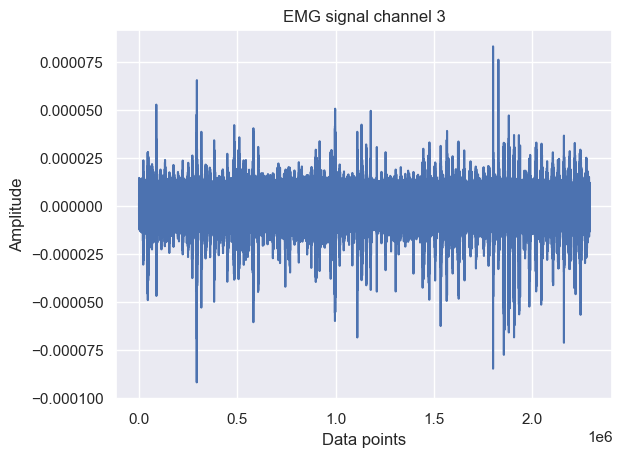

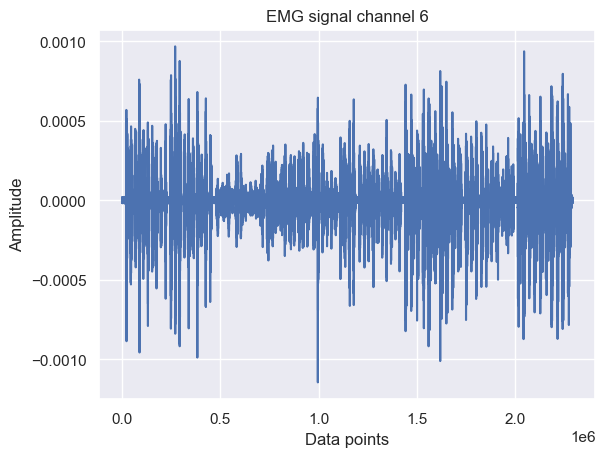

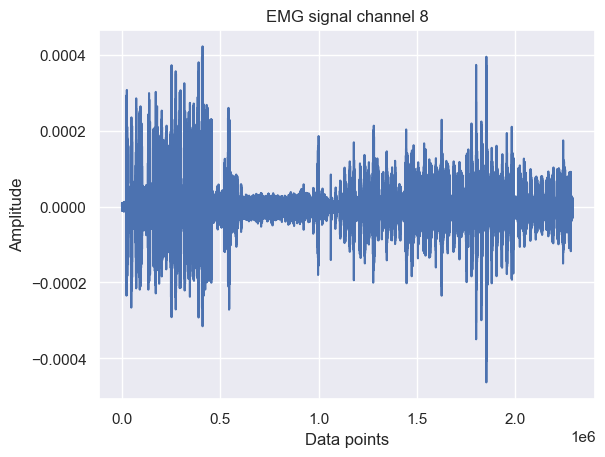

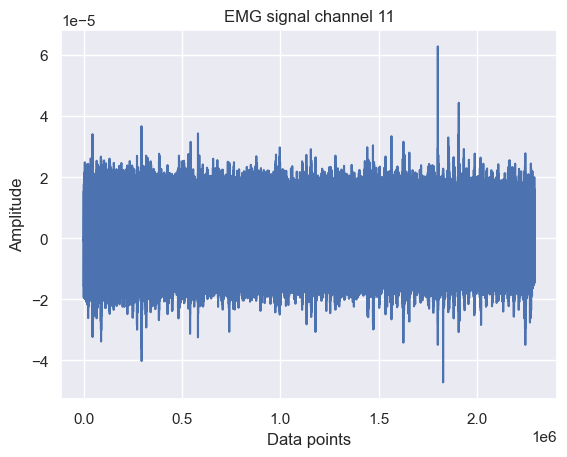

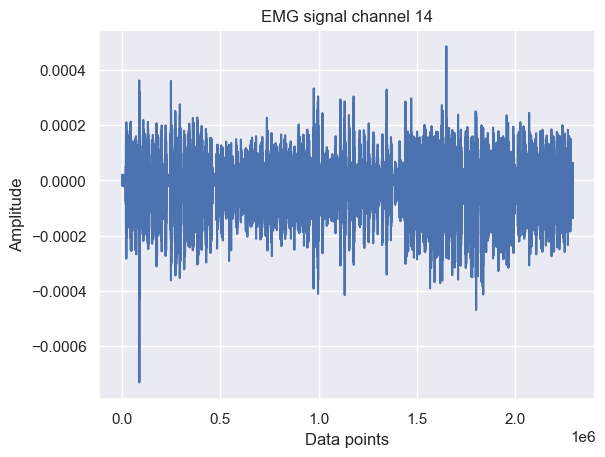

In [7]:
emg_data_filtered_train = emg_data_train.copy()
emg_data_filtered_val = emg_data_val.copy()
emg_data_filtered_test = emg_data_test.copy()


# plot filtered signals
for index, channel in enumerate(channels_to_keep):
    fig, ax = plt.subplots()
    ax.plot(emg_data_filtered_train[:, channel])   
    ax.set_title("EMG signal channel {}".format(channel+1))
    ax.set_xlabel("Data points")
    ax.set_ylabel("Amplitude")

We can see when the channel is picking up signals from the muscles. Let's check the signal quality to decide on the signal processing techniques.

In [8]:
# Notch filter at 320 Hertz, to filter big spike
fs = 2_000
sos = butter(N=4, Wn=(320 - 2, 320 + 2), fs=fs, btype="bandstop", output="sos")
emg_data_filtered_train[:, 10] = sosfiltfilt(sos, emg_data_filtered_train[:,10].T).T



Max power frequency [Hz] 42.96875
Max power frequency [Hz] 128.90625
Max power frequency [Hz] 113.28125
Max power frequency [Hz] 320.3125
Max power frequency [Hz] 85.9375


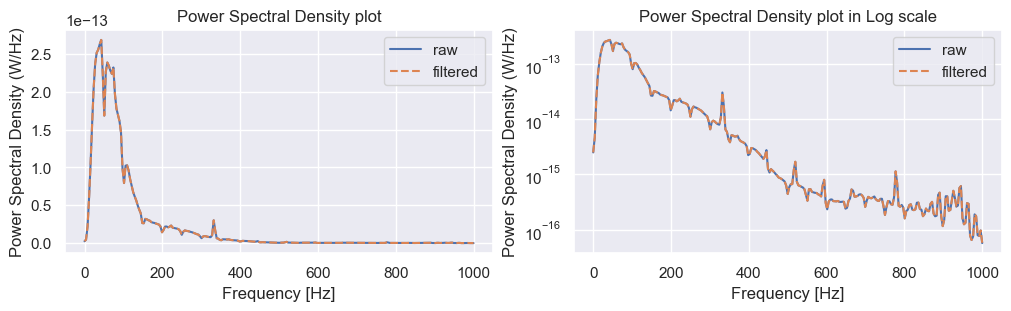

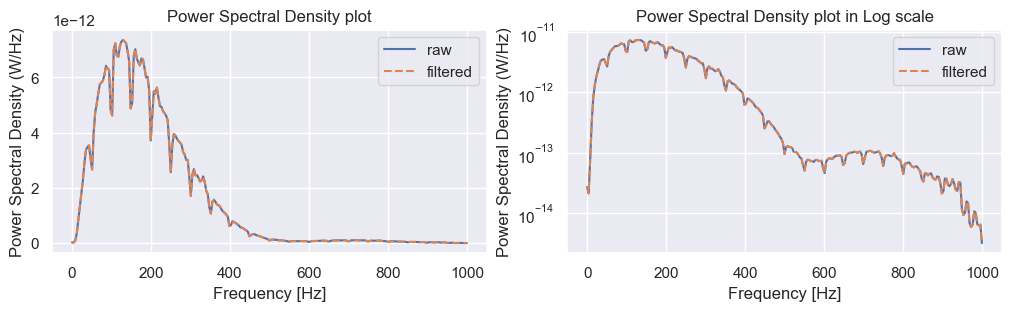

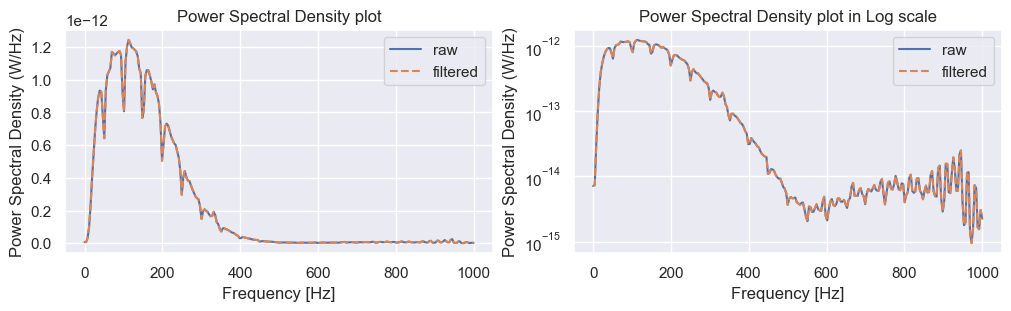

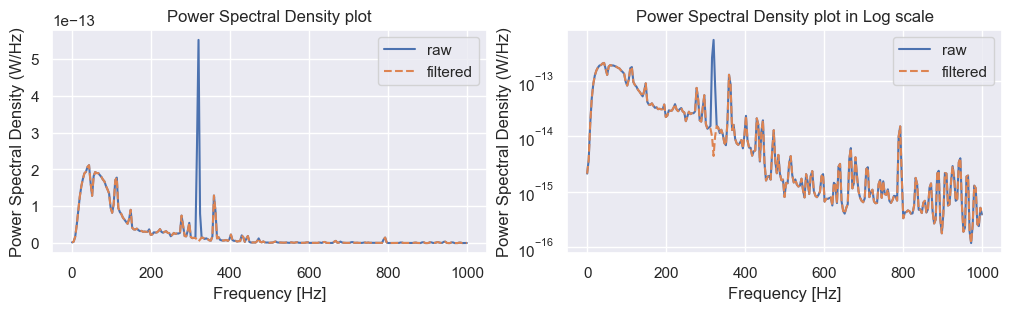

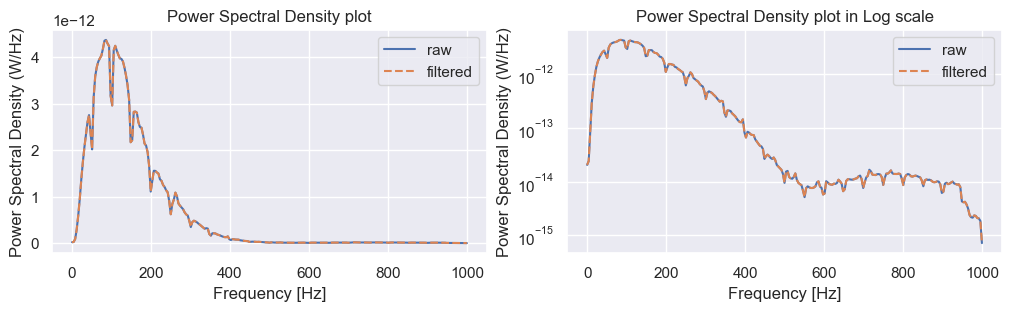

In [9]:
#power spectral denisty plots
for channel in channels_to_keep: 
    freqs_pre, Pxx_pre = welch(emg_data_train[:, channel], fs=fs, nperseg=512)
    freqs_post, Pxx_post = welch(emg_data_filtered_train[:, channel], fs=fs, nperseg=512)

    fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3))
    ax[0].plot(freqs_pre, Pxx_pre, label="raw")
    ax[0].plot(freqs_post, Pxx_post, linestyle="--", label="filtered")
    ax[0].legend()
    ax[0].set_xlabel("Frequency [Hz]")
    ax[0].set_ylabel("Power Spectral Density (W/Hz)")
    ax[0].set_title("Power Spectral Density plot")

    ax[1].semilogy(freqs_pre, Pxx_pre, label="raw")
    ax[1].semilogy(freqs_post, Pxx_post, linestyle="--", label="filtered")
    ax[1].legend()
    ax[1].set_xlabel("Frequency [Hz]")
    ax[1].set_ylabel("Power Spectral Density (W/Hz)")
    ax[1].set_title("Power Spectral Density plot in Log scale")
    max_power_index = np.argmax(Pxx_pre)
    max_power_frequency = freqs_pre[max_power_index]
    print("Max power frequency [Hz]", max_power_frequency)

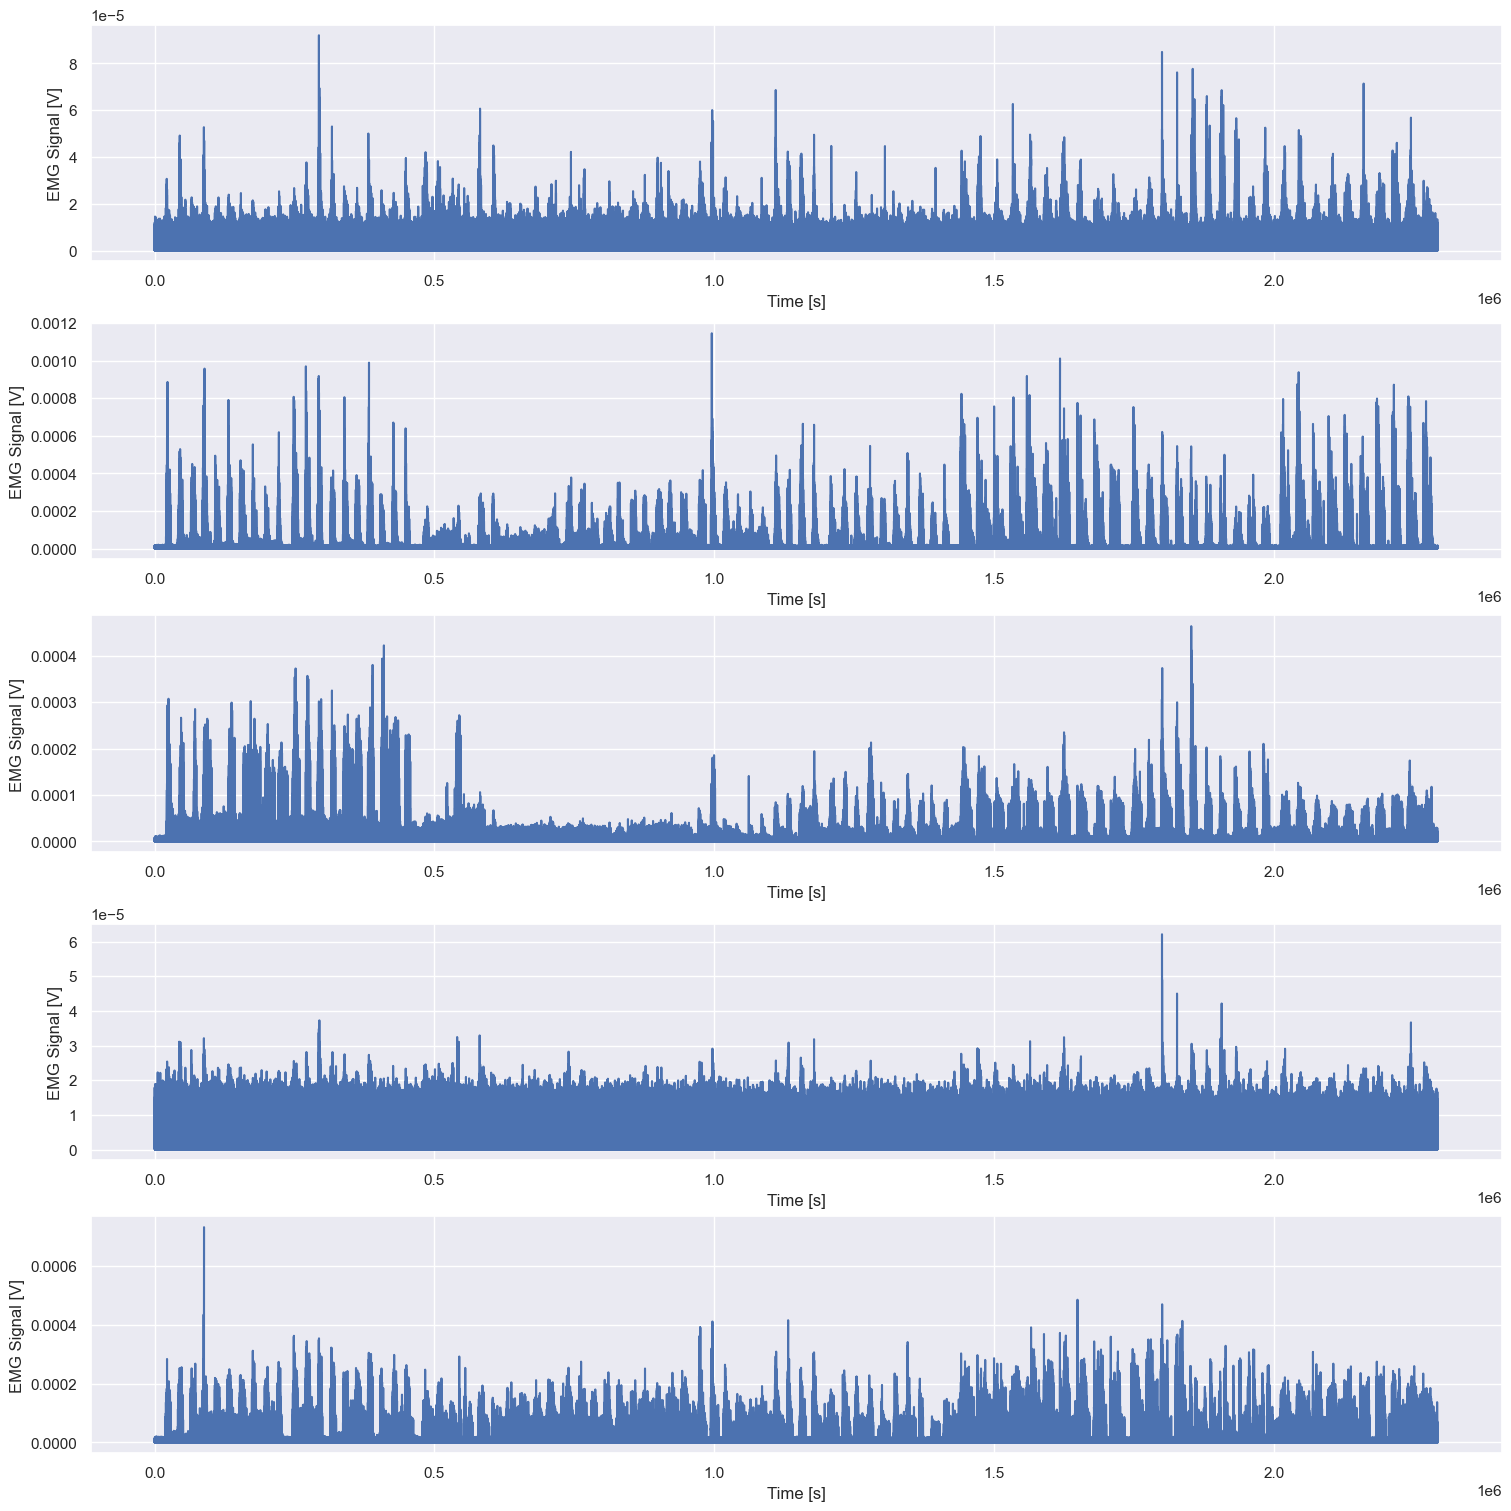

In [10]:
# Rectification of the signals

emg_rectified_train = np.abs(emg_data_filtered_train) # Rectify the signal
emg_rectified_val = np.abs(emg_data_filtered_val) # Rectify the signal
emg_rectified_test = np.abs(emg_data_filtered_test) # Rectify the signal
fig, ax = plt.subplots(5, 1, constrained_layout=True, figsize=(15, 15))
for idx, channel in enumerate(channels_to_keep):
    ax[idx].plot(emg_rectified_train[:, channel])
    ax[idx].set_xlabel("Time [s]")
    ax[idx].set_ylabel("EMG Signal [V]")

The signal seems to be minimally influenced by the powerline noise. Therefore, we can save the powerline filtering and proceed directly with the enveloping.

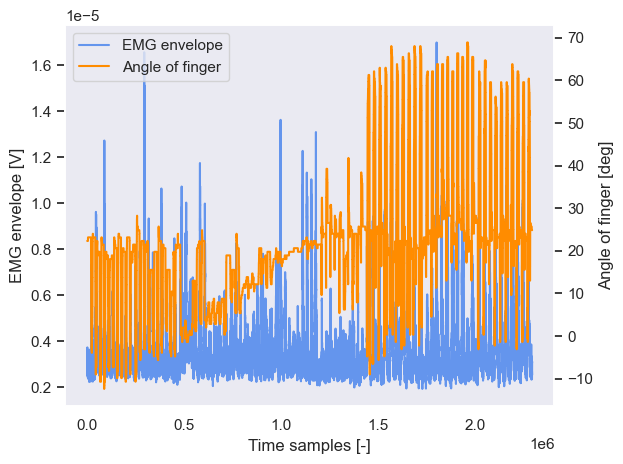

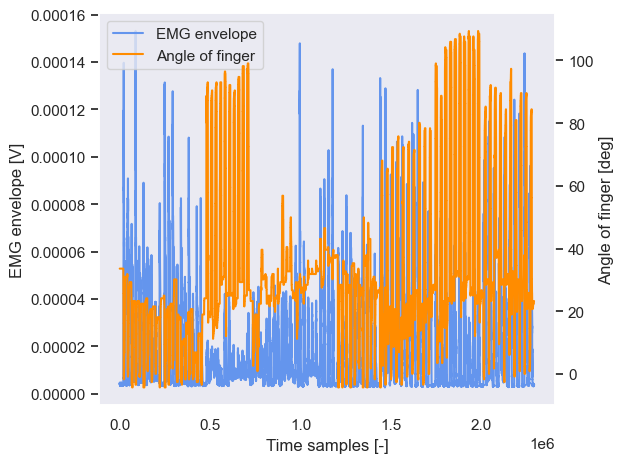

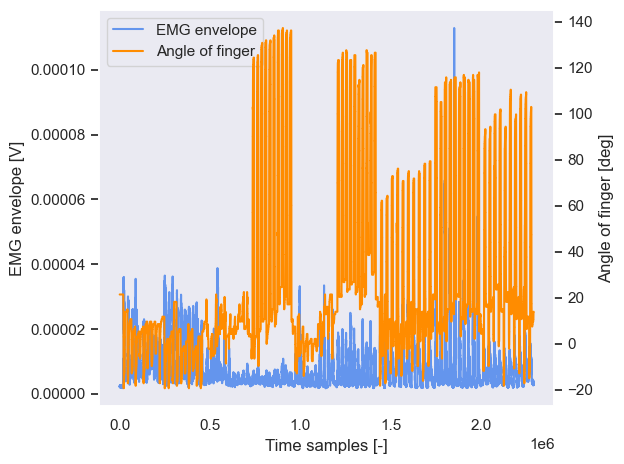

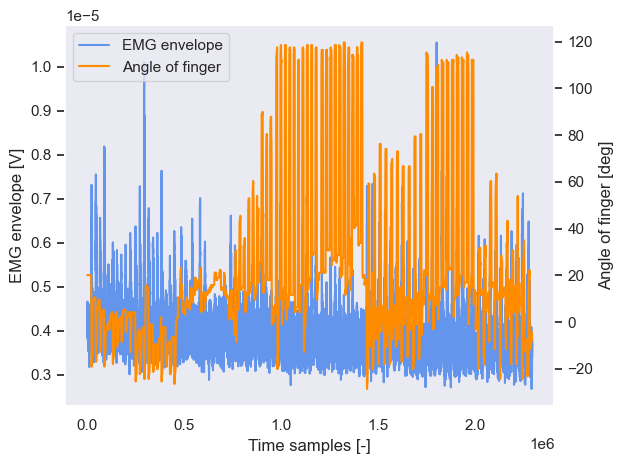

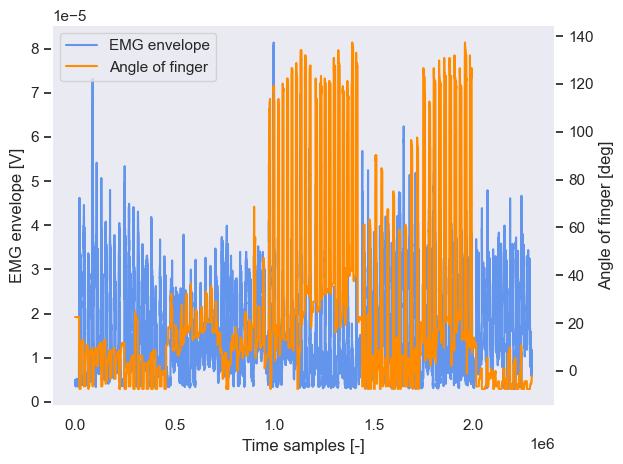

In [11]:
## Cell used for enveloping the signal

mov_mean_size = 400
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size
EMG_envelopes_train = convolve1d(emg_rectified_train, weights=mov_mean_weights, axis=0)
EMG_envelopes_val = convolve1d(emg_rectified_val, weights=mov_mean_weights, axis=0)
EMG_envelopes_test = convolve1d(emg_rectified_test, weights=mov_mean_weights, axis=0)
for idx, channel in enumerate(channels_to_keep):
    fig, ax = plt.subplots()
    ax.plot(EMG_envelopes_train[:, channel],color = 'cornflowerblue', label="EMG envelope")
    ax.set_ylabel("EMG envelope [V]")
    ax.set_xlabel("Time samples [-]")
    ax.grid(False)

    finger_angle_ax = ax.twinx()
    finger_angle_ax.plot(glove_data_index_train[:, idx], color="darkorange", label="Angle of finger")
    finger_angle_ax.set_ylabel("Angle of finger [deg]")
    finger_angle_ax.grid(False)

    # Get handles and labels for legend
    emg_handles, emg_labels = ax.get_legend_handles_labels()
    finger_angle_handles, finger_angle_labels = finger_angle_ax.get_legend_handles_labels()

    # Combine handles and labels
    combined_handles = emg_handles + finger_angle_handles
    combined_labels = emg_labels + finger_angle_labels

    # Create a single legend
    ax.legend(combined_handles, combined_labels, loc='upper left')
    plt.tight_layout()

To process the dataset efficiently, we divide it into overlapping sliding windows. This approach allows us to extract smaller segments of the EMG data, each corresponding to a specific time interval. The sliding window technique ensures that we capture temporal patterns in the signal by dividing it into time segments, while maintaining continuity through overlapping segments.

In [12]:
def extract_time_windows_regression(EMG: np.ndarray, Label: np.ndarray, fs: int, win_len: int, step: int):
# This function is used to cut the time windows from the raw EMG 
# It return a lists containing the EMG of each time window.
# It also returns the target corresponding to the time of the end of the window
    """
    This function is defined to perform an overlapping sliding window 
    :param EMG: Numpy array containing the data
    :param Label: Numpy array containing the targets
    :param fs: the sampling frequency of the signal
    :param win_len: The size of the windows (in seconds)
    :param step: The step size between windows (in seconds)

    :return: A Numpy array containing the windows
    :return: A Numpy array containing the targets aligned for each window
    :note: The lengths of both outputs are the same
    """
    
    n,m = EMG.shape
    win_len = int(win_len*fs)
    start_points = np.arange(0,n-win_len,int(step*fs))
    end_points = start_points + win_len

    EMG_windows = np.zeros((len(start_points),win_len,m))
    Labels_window = np.zeros((len(start_points),win_len,Label.shape[1]))
    for i in range(len(start_points)):
        EMG_windows[i,:,:] = EMG[start_points[i]:end_points[i],:]
        Labels_window[i,:,:] = Label[start_points[i]:end_points[i],:]
    

    return EMG_windows, Labels_window

In [13]:
## Cell used to extract the sliding time windows from the data

fs = 2000  # [Hz], from dataset description
emg_window_length_sec = 128e-3  # [s]
incremental_window_length_sec = 50e-3  # [s]

# extract over lapping time windows on the whole dataset
EMG_windows_train, Labels_windows_train = extract_time_windows_regression(emg_rectified_train[:,channels_to_keep], glove_data_index_train, fs, emg_window_length_sec, incremental_window_length_sec)
EMG_windows_test, Labels_windows_test = extract_time_windows_regression(emg_rectified_test[:,channels_to_keep], glove_data_index_test, fs, emg_window_length_sec, incremental_window_length_sec)
EMG_windows_val, Labels_windows_val = extract_time_windows_regression(emg_rectified_val[:,channels_to_keep], glove_data_index_val, fs, emg_window_length_sec, incremental_window_length_sec)

print(f"EMG train data shape: {EMG_windows_train.shape}, Train label shape: {Labels_windows_train.shape}")
print(f"EMG test data shape: {EMG_windows_test.shape}, Test label shape: {Labels_windows_test.shape}")
print(f"EMG validation data shape: {EMG_windows_val.shape}, Train label shape: {Labels_windows_val.shape}")

EMG train data shape: (22923, 256, 5), Train label shape: (22923, 256, 5)
EMG test data shape: (5289, 256, 5), Test label shape: (5289, 256, 5)
EMG validation data shape: (23133, 256, 5), Train label shape: (23133, 256, 5)


Now that we have the windows, lets extract some features again. 

In [14]:
def extract_features(EMG_windows: np.ndarray, Labels_windows: np.ndarray):
    """
    This function is defined to extract the mean and standard deviation of each window
    :param EMG_windows: A Numpy array containing the windows
    :return: A Numpy array containing the mean and standard deviation of each window and the mean of the labels window
    """
    # along axis 1, which is the time axis
    EMG_mean = np.mean(EMG_windows, axis = 1)
    #EMG_std = np.std(EMG_windows, axis = 1)
    # = np.max(EMG_windows, axis = 1)
    EMG_wilson_amplitude = np.mean(np.abs(np.diff(EMG_windows, axis=1)), axis=1)
    #EMG_rms = np.sqrt(np.mean(EMG_windows**2, axis=1))
    #EMG_psd = np.mean(np.abs(np.fft.fft(EMG_windows, axis=1))**2, axis=1)
    EMG_waveform_length = np.sum(np.abs(np.diff(EMG_windows, axis=1)), axis=1)
    EMG_slope_sign_change = np.sum(np.diff(np.sign(np.diff(EMG_windows, axis=1)), axis=1) != 0, axis=1)
    EMG_log_variance = np.log(np.var(EMG_windows, axis=1) + 1e-8)  # Adding a small constant to avoid log(0)

    Labels_mean = np.mean(Labels_windows,axis=1)

    # Concatenate the mean and std of each window
    EMG_extracted_features = np.concatenate((EMG_mean, EMG_wilson_amplitude, EMG_waveform_length, EMG_slope_sign_change, EMG_log_variance), axis=1)
    return EMG_extracted_features, Labels_mean

In [15]:
# Extracting the features

EMG_train_extracted_features, Labels_train_mean = extract_features(EMG_windows_train,Labels_windows_train)
EMG_test_extracted_features,  Labels_test_mean  = extract_features(EMG_windows_test,Labels_windows_test)
EMG_val_extracted_features,  Labels_val_mean  = extract_features(EMG_windows_val,Labels_windows_val)

print("EMG train extracted features shape: {}, Finger labels feature shape:{}".format(EMG_train_extracted_features.shape, Labels_train_mean.shape))
print("EMG test extracted features shape: {}, Finger labels feature shape:{}".format(EMG_test_extracted_features.shape, Labels_test_mean.shape))
print("EMG validation extracted features shape: {}, Finger labels feature shape:{}".format(EMG_val_extracted_features.shape, Labels_val_mean.shape))

EMG train extracted features shape: (22923, 25), Finger labels feature shape:(22923, 5)
EMG test extracted features shape: (5289, 25), Finger labels feature shape:(5289, 5)
EMG validation extracted features shape: (23133, 25), Finger labels feature shape:(23133, 5)


In [16]:
from sklearn.preprocessing import StandardScaler

def standard_normalize_features(features: np.ndarray):
    """
    Normalize the extracted features using the min-max method.
    :param features: Numpy array of features
    :return: Normalized features
    """
    return StandardScaler().fit_transform(features)

In [17]:
## Cell used to normalize the features 

# Fit the scaler only on the training set
scaler = StandardScaler()
scaler.fit(EMG_train_extracted_features)

# Transform all sets using the scaler fitted on the training set
EMG_train_extracted_features_norm = scaler.transform(EMG_train_extracted_features)
EMG_test_extracted_features_norm  = scaler.transform(EMG_test_extracted_features)
EMG_val_extracted_features_norm   = scaler.transform(EMG_val_extracted_features)

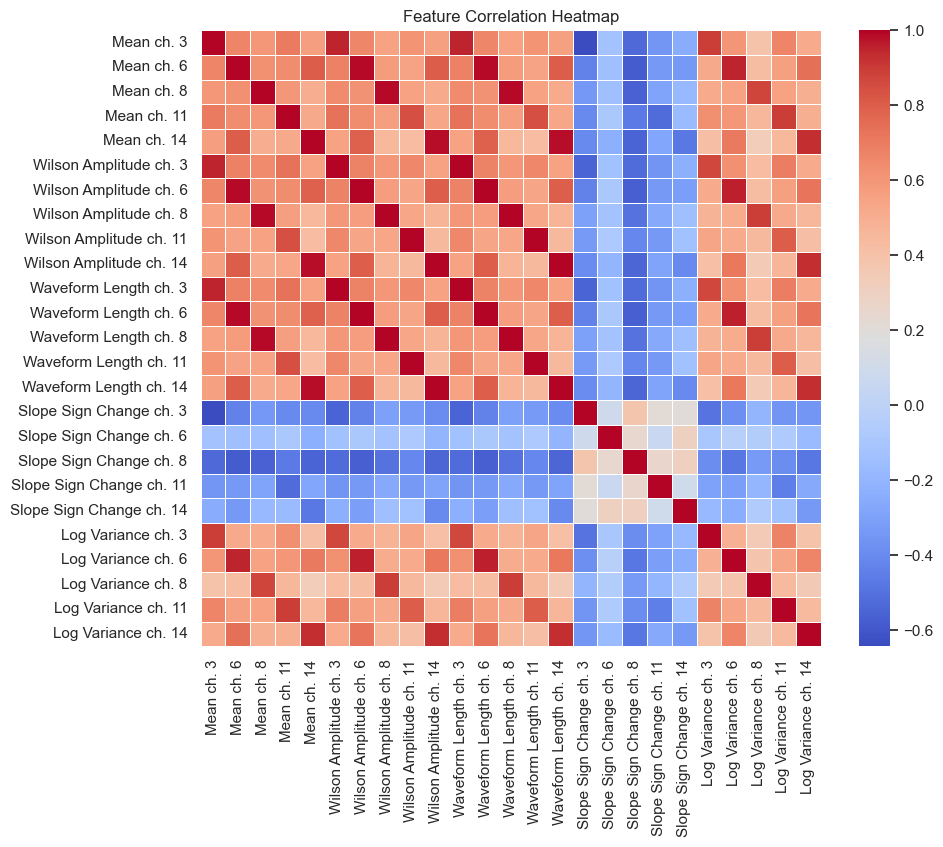

In [18]:
## Cell used to compute the correlation between the features

# Create a list of feature names
feature_names = np.empty(25, dtype=object)
features = ['Mean', 'Wilson Amplitude','Waveform Length', 'Slope Sign Change', 'Log Variance']
for i, feature in enumerate(features):
    for j, channel in enumerate(channels_to_keep):
        feature_names[len(channels_to_keep)*i+j] = feature + ' ch. ' + str(channel+1) 

# Create a DataFrame with the extracted features
features_df = pd.DataFrame(EMG_train_extracted_features_norm, columns=feature_names)

# Compute correlation matrix
correlation_matrix = features_df.corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

# Model training and testing

In [ ]:
## Cell to train the model and tune the hyperparameters
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

# Select the training features and labels
X_train = EMG_train_extracted_features_norm
y_train = Labels_train_mean

# Select the training hyperparameters (nested loops will train the model with all possible combinations)
n_est_list = [100, 200, 300]
lr_list = [0.02, 0.05, 0.1]
max_d_list = [3, 4, 5]

# Train the model with all possible combinations of hyperparameters
for n_est_i in n_est_list:
    for lr_i in lr_list:
        for max_d_i in max_d_list:
            base_model = GradientBoostingRegressor(n_estimators=n_est_i, learning_rate=lr_i, max_depth=max_d_i, random_state=42)
            model_gb = MultiOutputRegressor(base_model)        
            model_gb.fit(X_train, y_train)
            joblib.dump(model_gb, 'gb_regression_model_{}_{}_{}.pkl'.format(n_est_i, int(lr_i*100), max_d_i))



In [33]:
## Cell used to compaute the performance metrics on the validation set of the models given by all the combinations of chosen hyperparameters
#  The resutls are stored in a dictionary

from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
import joblib

y_val = Labels_val_mean 
X_val = EMG_val_extracted_features_norm

# n_est_list, lr_list, max_d_list are your lists of parameter values
n_est_list = [100, 200, 300]
lr_list = [0.02, 0.05, 0.1]
max_d_list = [3, 4, 5]

metrics_dict = {}

for n_e in n_est_list:
    for l in lr_list:
        for md in max_d_list:
            # Load the model
            model = joblib.load('gb_regression_model_{}_{}_{}.pkl'.format(n_e, int(l*100), md))
            
            # Predict
            y_pred_val = model.predict(X_val)
            
            # Compute metrics
            MSE  = mean_squared_error(y_val, y_pred_val)
            MAE = mean_absolute_error(y_val, y_pred_val)
            r2 = r2_score(y_val, y_pred_val)
            
            # Adjusted R²
            n = X_val.shape[0]
            p = X_val.shape[1]
            adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
            
            # Median Absolute Error
            MedAE = median_absolute_error(y_val, y_pred_val)
            
            # Store the metrics in the dictionary
            metrics_dict[(n_e, l, md)] = {
                'MSE': MSE,
                'MAE': MAE,
                'r2': r2,
                'adj_r2': adjusted_r2,
                'MedAE': MedAE
            }

# Access metrics for a specific model:
# metrics_dict[(some_n_est, some_lr, some_max_d)]

In [34]:
# Save the metrics in a csv file
metrics_pd = pd.DataFrame(metrics_dict)
metrics_pd.to_csv('metrics_val_data.csv')

In [35]:
# function used to find the model with the lowest MSE among those in the dictionary
def find_min_mse(metrics_dict):
    sorted_keys = sorted(metrics_dict.keys(), key=lambda x: (x[0], x[1], x[2]))
    min_mse = 1000
    for (n_est, lr, max_d) in sorted_keys:
        metrics = metrics_dict[(n_est, lr, max_d)]
        if metrics['MSE'] < min_mse:
            min_mse = metrics['MSE']
            best_params = (n_est, lr, max_d)
    return best_params, min_mse


In [36]:
best_params, min_mse = find_min_mse(metrics_dict)

print("Bets parameters found: \n number of estimators: {} \n learning rate: {} \n max depth: {}".format(best_params[0], best_params[1], best_params[2]))
print("Corresponding MSE: " + str(min_mse))

Bets parameters found: 
 number of estimators: 200 
 learning rate: 0.05 
 max depth: 5
Corresponding MSE: 561.6760254367986


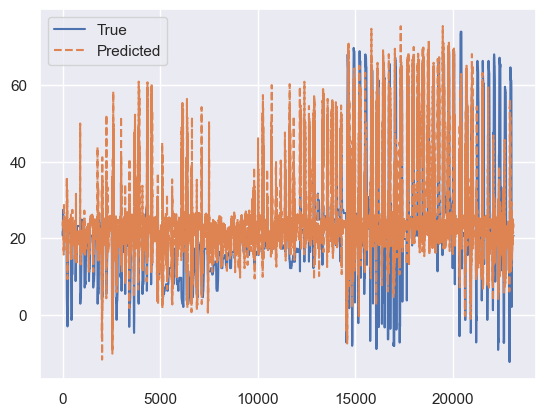

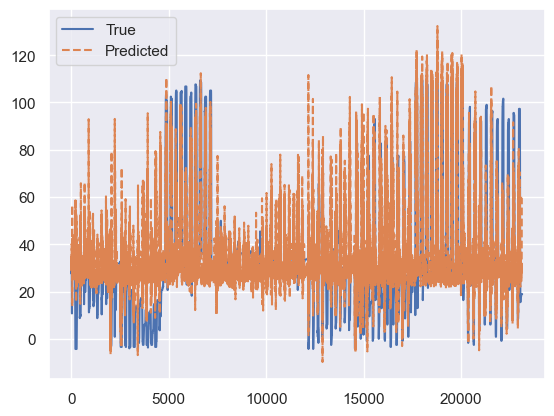

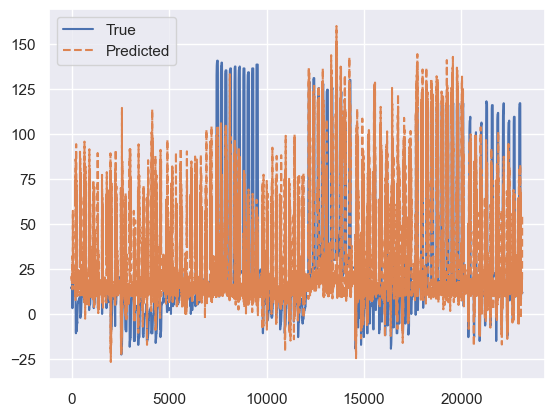

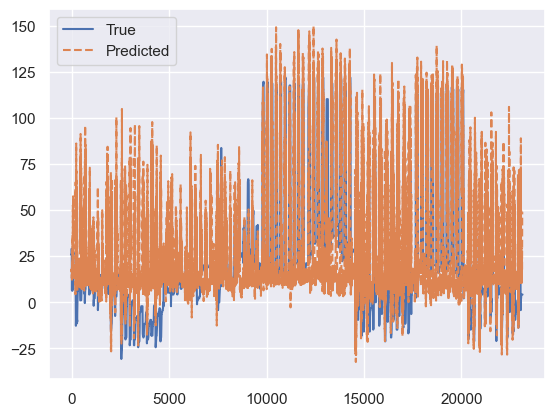

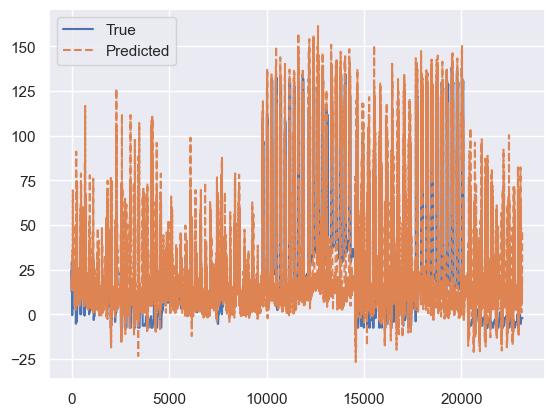

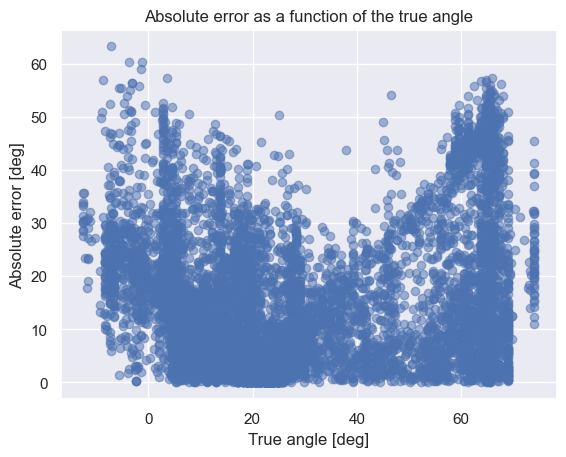

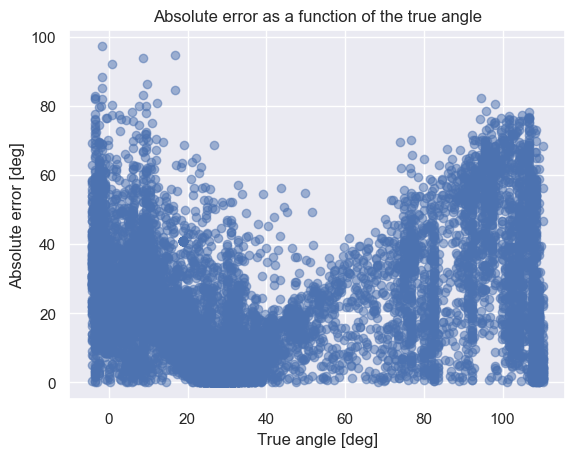

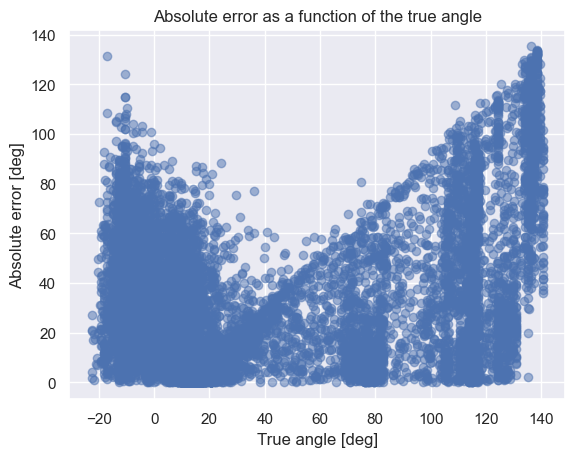

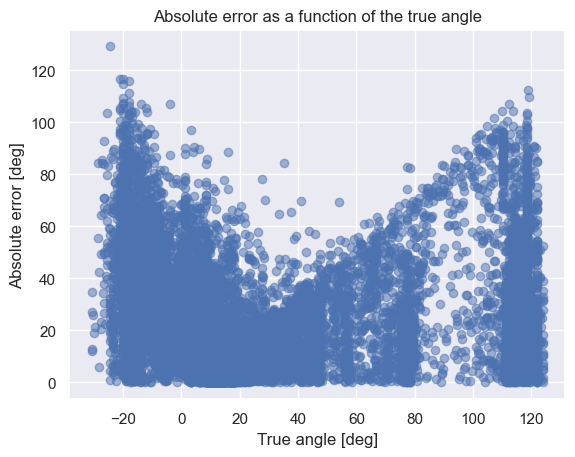

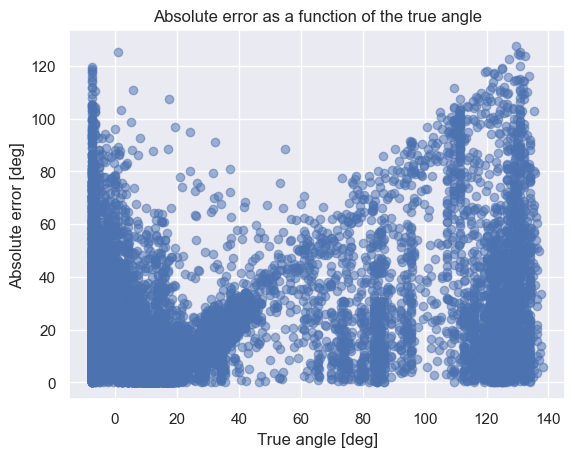

In [32]:
## Cell used to plot the true and predicted values for finger angles for all channels 
## on the validation set, as well as the absolute error as a function of the angle

# Select the validation features and labels
y_val = Labels_val_mean 
X_val = EMG_val_extracted_features_norm

# Choose the parameters of a model to load
n_e = best_params[0]
l = best_params[1]
md = best_params[2]

# Load the model
model = joblib.load('gb_regression_model_{}_{}_{}.pkl'.format(n_e, int(l*100), md))

# Predict
y_pred_val = model.predict(X_val)

# Plot the true and predicted values for finger angles
for i in range(5):
    fig, ax = plt.subplots()
    ax.plot(y_val[:,i], label="True")
    ax.plot(y_pred_val[:,i], linestyle="--", label="Predicted")
    ax.legend()

plt.show()

# Plot absolute error as a function of the angle 
for i in range(5):
    
    error = np.abs(y_val[:,i] - y_pred_val[:,i])
    #plt.figure(figsize=(10, 6))
    plt.plot(y_val[:,i], error, 'o', alpha=0.5)
    plt.xlabel('True angle [deg]')
    plt.ylabel('Absolute error [deg]')
    plt.title('Absolute error as a function of the true angle')
    plt.show()

Now, we will train a model once more, on the concatenation of the original training and validation sets with the best parameters found, to finally check the performance on the test set.

In [24]:
emg_rectified_train_v2 = np.concatenate((emg_rectified_train[:,channels_to_keep], emg_rectified_val[:,channels_to_keep]), axis=0)
glove_data_index_train_v2 = np.concatenate((glove_data_index_train, glove_data_index_val), axis=0)

In [25]:
EMG_windows_train_v2, Labels_windows_train_v2 = extract_time_windows_regression(emg_rectified_train_v2, glove_data_index_train_v2, fs, emg_window_length_sec, incremental_window_length_sec)

In [26]:
EMG_train_extracted_features_v2, Labels_train_mean_v2 = extract_features(EMG_windows_train_v2,Labels_windows_train_v2)

In [27]:
EMG_train_extracted_features_norm_v2 = scaler.transform(EMG_train_extracted_features_v2)

In [ ]:
# Select the training features and labels
X_train = EMG_train_extracted_features_norm_v2
y_train = Labels_train_mean_v2

# Select the training hyperparameters (nested loops will train the model with all possible combinations)
n_est = best_params[0]
lr = best_params[1]
max_d = best_params[2]

base_model = GradientBoostingRegressor(n_estimators=n_est, learning_rate=lr, max_depth=max_d, random_state=42)
model_gb = MultiOutputRegressor(base_model)        
model_gb.fit(X_train, y_train)
joblib.dump(model_gb, 'final_gb_regression_model_{}_{}_{}.pkl'.format(n_est, int(lr*100), max_d))

['no_envelope_no_psd_no_concat/gb_regression_model_200_5_5.pkl']

In [29]:
## Cell used to compare the performance of the model on the test set versus the training set

n_est = best_params[0]
lr = best_params[1]
max_d = best_params[2]

# Load the model
model = joblib.load('final_gb_regression_model_{}_{}_{}.pkl'.format(n_est, int(lr*100), max_d))

# Predict on the validation set
y_test = Labels_test_mean 
X_test = EMG_test_extracted_features_norm
y_pred_gb_test = model.predict(X_test)

# Predict on the training set
y_train = Labels_train_mean_v2
X_train = EMG_train_extracted_features_norm_v2
y_pred_gb_train = model.predict(X_train)

# MSE
MSE_test  = mean_squared_error(y_test, y_pred_gb_test)
MSE_train = mean_squared_error(y_train, y_pred_gb_train)

# MAE
MAE_test  = mean_absolute_error(y_test, y_pred_gb_test)
MAE_train = mean_absolute_error(y_train, y_pred_gb_train)

# R²
r2_test = r2_score(y_test, y_pred_gb_test)
r2_train = r2_score(y_train, y_pred_gb_train)

# Median Absolute Error
MedAE_test = median_absolute_error(y_test, y_pred_gb_test)
MedAE_train = median_absolute_error(y_train, y_pred_gb_train)

# Print the results
print(f"MSE test set: {MSE_test}")
print(f"MSE train set: {MSE_train}")
print(f"MAE test set: {MAE_test}")
print(f"MAE train set: {MAE_train}")
print(f"R² test set: {r2_test}")
print(f"R² train set: {r2_train}")
print(f"Median Absolute Error test set: {MedAE_test}")
print(f"Median Absolute Error train set: {MedAE_train}")

MSE test set: 461.3612910676831
MSE train set: 315.1463654716166
MAE test set: 12.598680546565532
MAE train set: 11.22123518209554
R² test set: 0.4516747911955177
R² train set: 0.678646472427826
Median Absolute Error test set: 6.538178183939214
Median Absolute Error train set: 6.6854486212664295


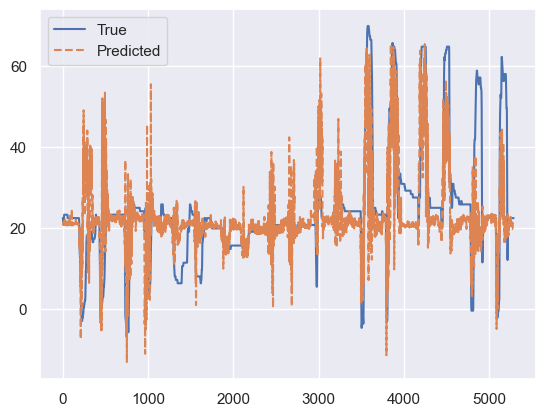

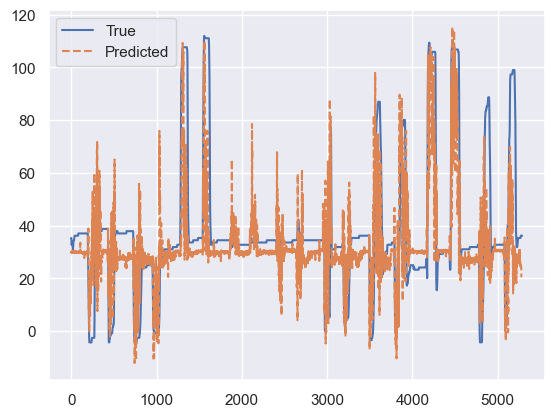

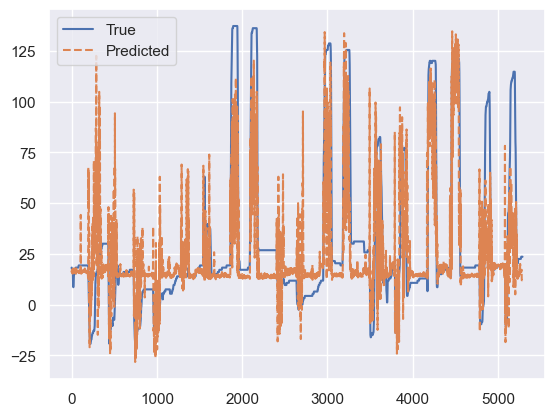

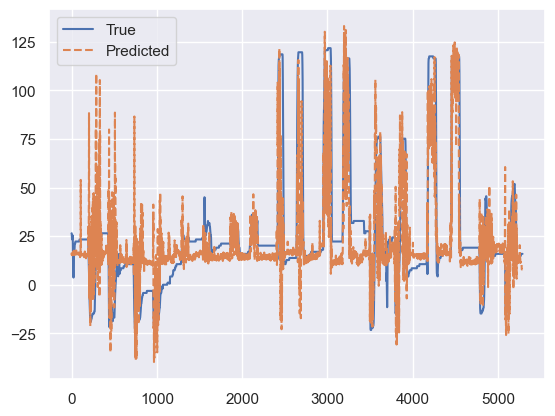

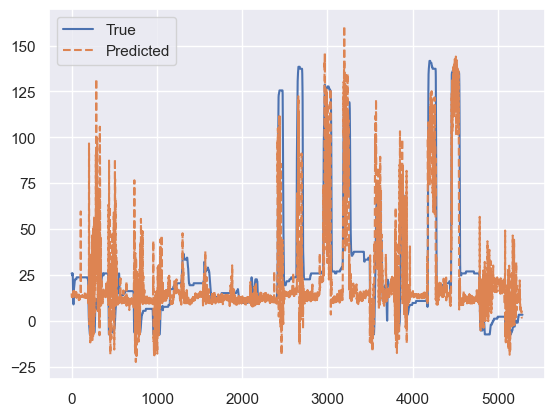

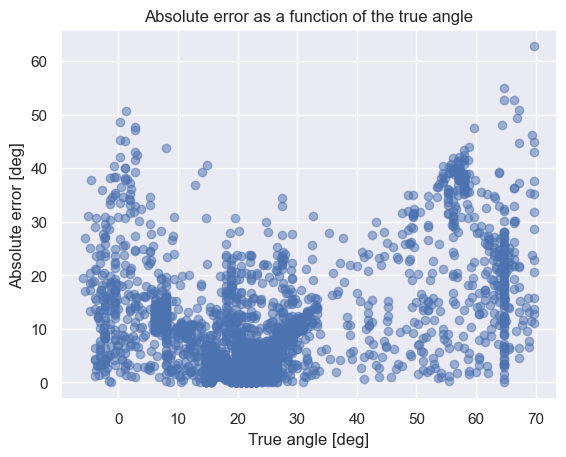

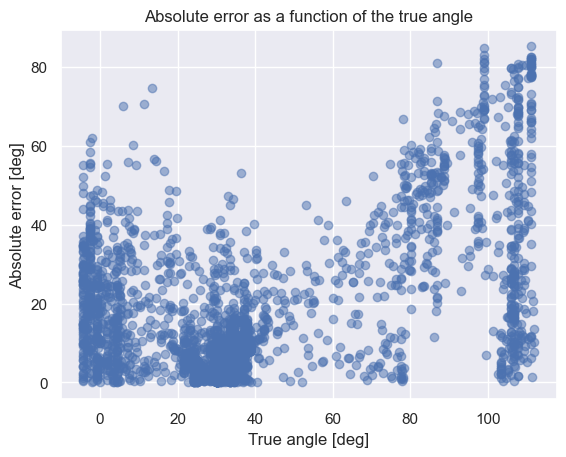

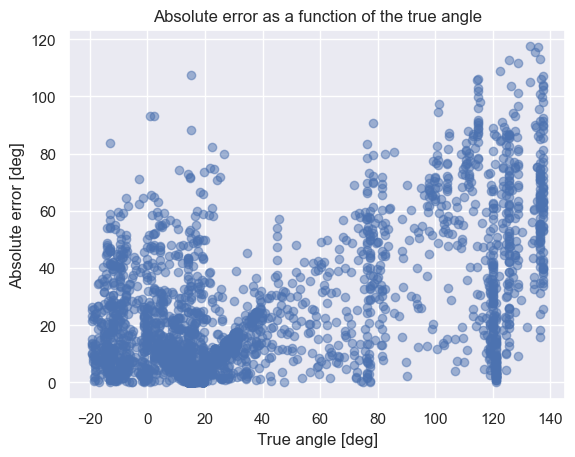

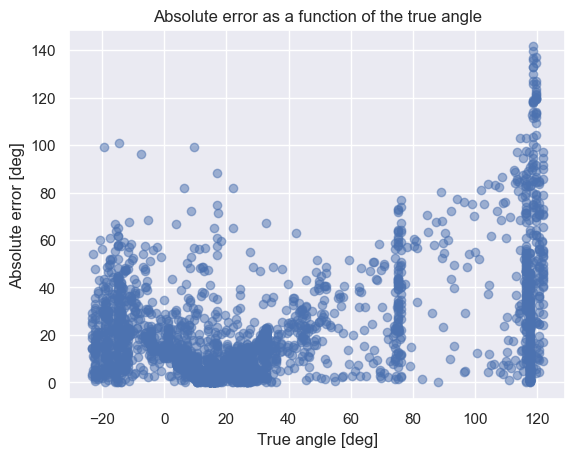

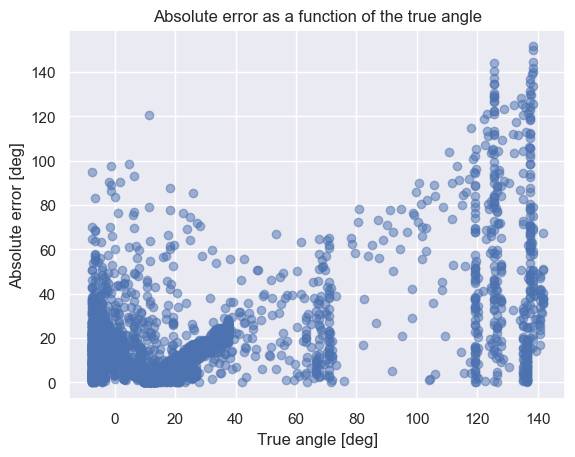

In [30]:
## Cell used to plot the true and predicted values for finger angles for all channels 
## on the test set, as well as the absolute error as a function of the angle

# Select the test features and labels
y_val = Labels_test_mean 
X_val = EMG_test_extracted_features_norm

# Choose the parameters of a model to load
n_e = best_params[0]
l = best_params[1]
md = best_params[2]

# Load the model
model = joblib.load('final_gb_regression_model_{}_{}_{}.pkl'.format(n_e, int(l*100), md))

# Predict
y_pred_val = model.predict(X_val)

# Plot the true and predicted values for finger angles
for i in range(5):
    fig, ax = plt.subplots()
    ax.plot(y_val[:,i], label="True")
    ax.plot(y_pred_val[:,i], linestyle="--", label="Predicted")
    ax.legend()

plt.show()

# Plot absolute error as a function of the angle 
for i in range(5):
    
    error = np.abs(y_val[:,i] - y_pred_val[:,i])
    #plt.figure(figsize=(10, 6))
    plt.plot(y_val[:,i], error, 'o', alpha=0.5)
    plt.xlabel('True angle [deg]')
    plt.ylabel('Absolute error [deg]')
    plt.title('Absolute error as a function of the true angle')
    plt.show()